In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
datapath = '../Datasets/2013 NY Offenses.csv'

crime_2013 = pd.read_csv(datapath, header=4, skipfooter=3, engine='python')

crime_2013.columns = ['city', 'population', 'violent crime', 'murder', 'rape (new definition)', 'rape (old definition)', 'robbery',
              'aggrevated assault', 'property_crime', 'burglary', 'larceny-theft', 'motor vehicle theft', 'arson']
df = crime_2013
df.head()

,city,population,violent crime,murder,rape (new definition),rape (old definition),robbery,aggrevated assault,property_crime,burglary,larceny-theft,motor vehicle theft,arson
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [3]:
#check info to begin data cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
city                     348 non-null object
population               348 non-null object
violent crime            348 non-null object
murder                   348 non-null int64
rape (new definition)    0 non-null float64
rape (old definition)    348 non-null object
robbery                  348 non-null object
aggrevated assault       348 non-null object
property_crime           348 non-null object
burglary                 348 non-null object
larceny-theft            348 non-null object
motor vehicle theft      348 non-null object
arson                    187 non-null float64
dtypes: float64(2), int64(1), object(10)
memory usage: 21.8+ KB


In [4]:
df = df.drop(labels='rape (new definition)', axis=1)
df.fillna(0, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
city                     348 non-null object
population               348 non-null object
violent crime            348 non-null object
murder                   348 non-null int64
rape (old definition)    348 non-null object
robbery                  348 non-null object
aggrevated assault       348 non-null object
property_crime           348 non-null object
burglary                 348 non-null object
larceny-theft            348 non-null object
motor vehicle theft      348 non-null object
arson                    348 non-null float64
dtypes: float64(1), int64(1), object(10)
memory usage: 19.1+ KB


In [6]:
for col in df.iloc[:, 1:]:
    df[col] = df[col].replace('[^0-9]+', '', regex=True)
    df[col] = df[col].astype('int64')

In [7]:
df.head()

,city,population,violent crime,murder,rape (old definition),robbery,aggrevated assault,property_crime,burglary,larceny-theft,motor vehicle theft,arson
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142,0
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,0


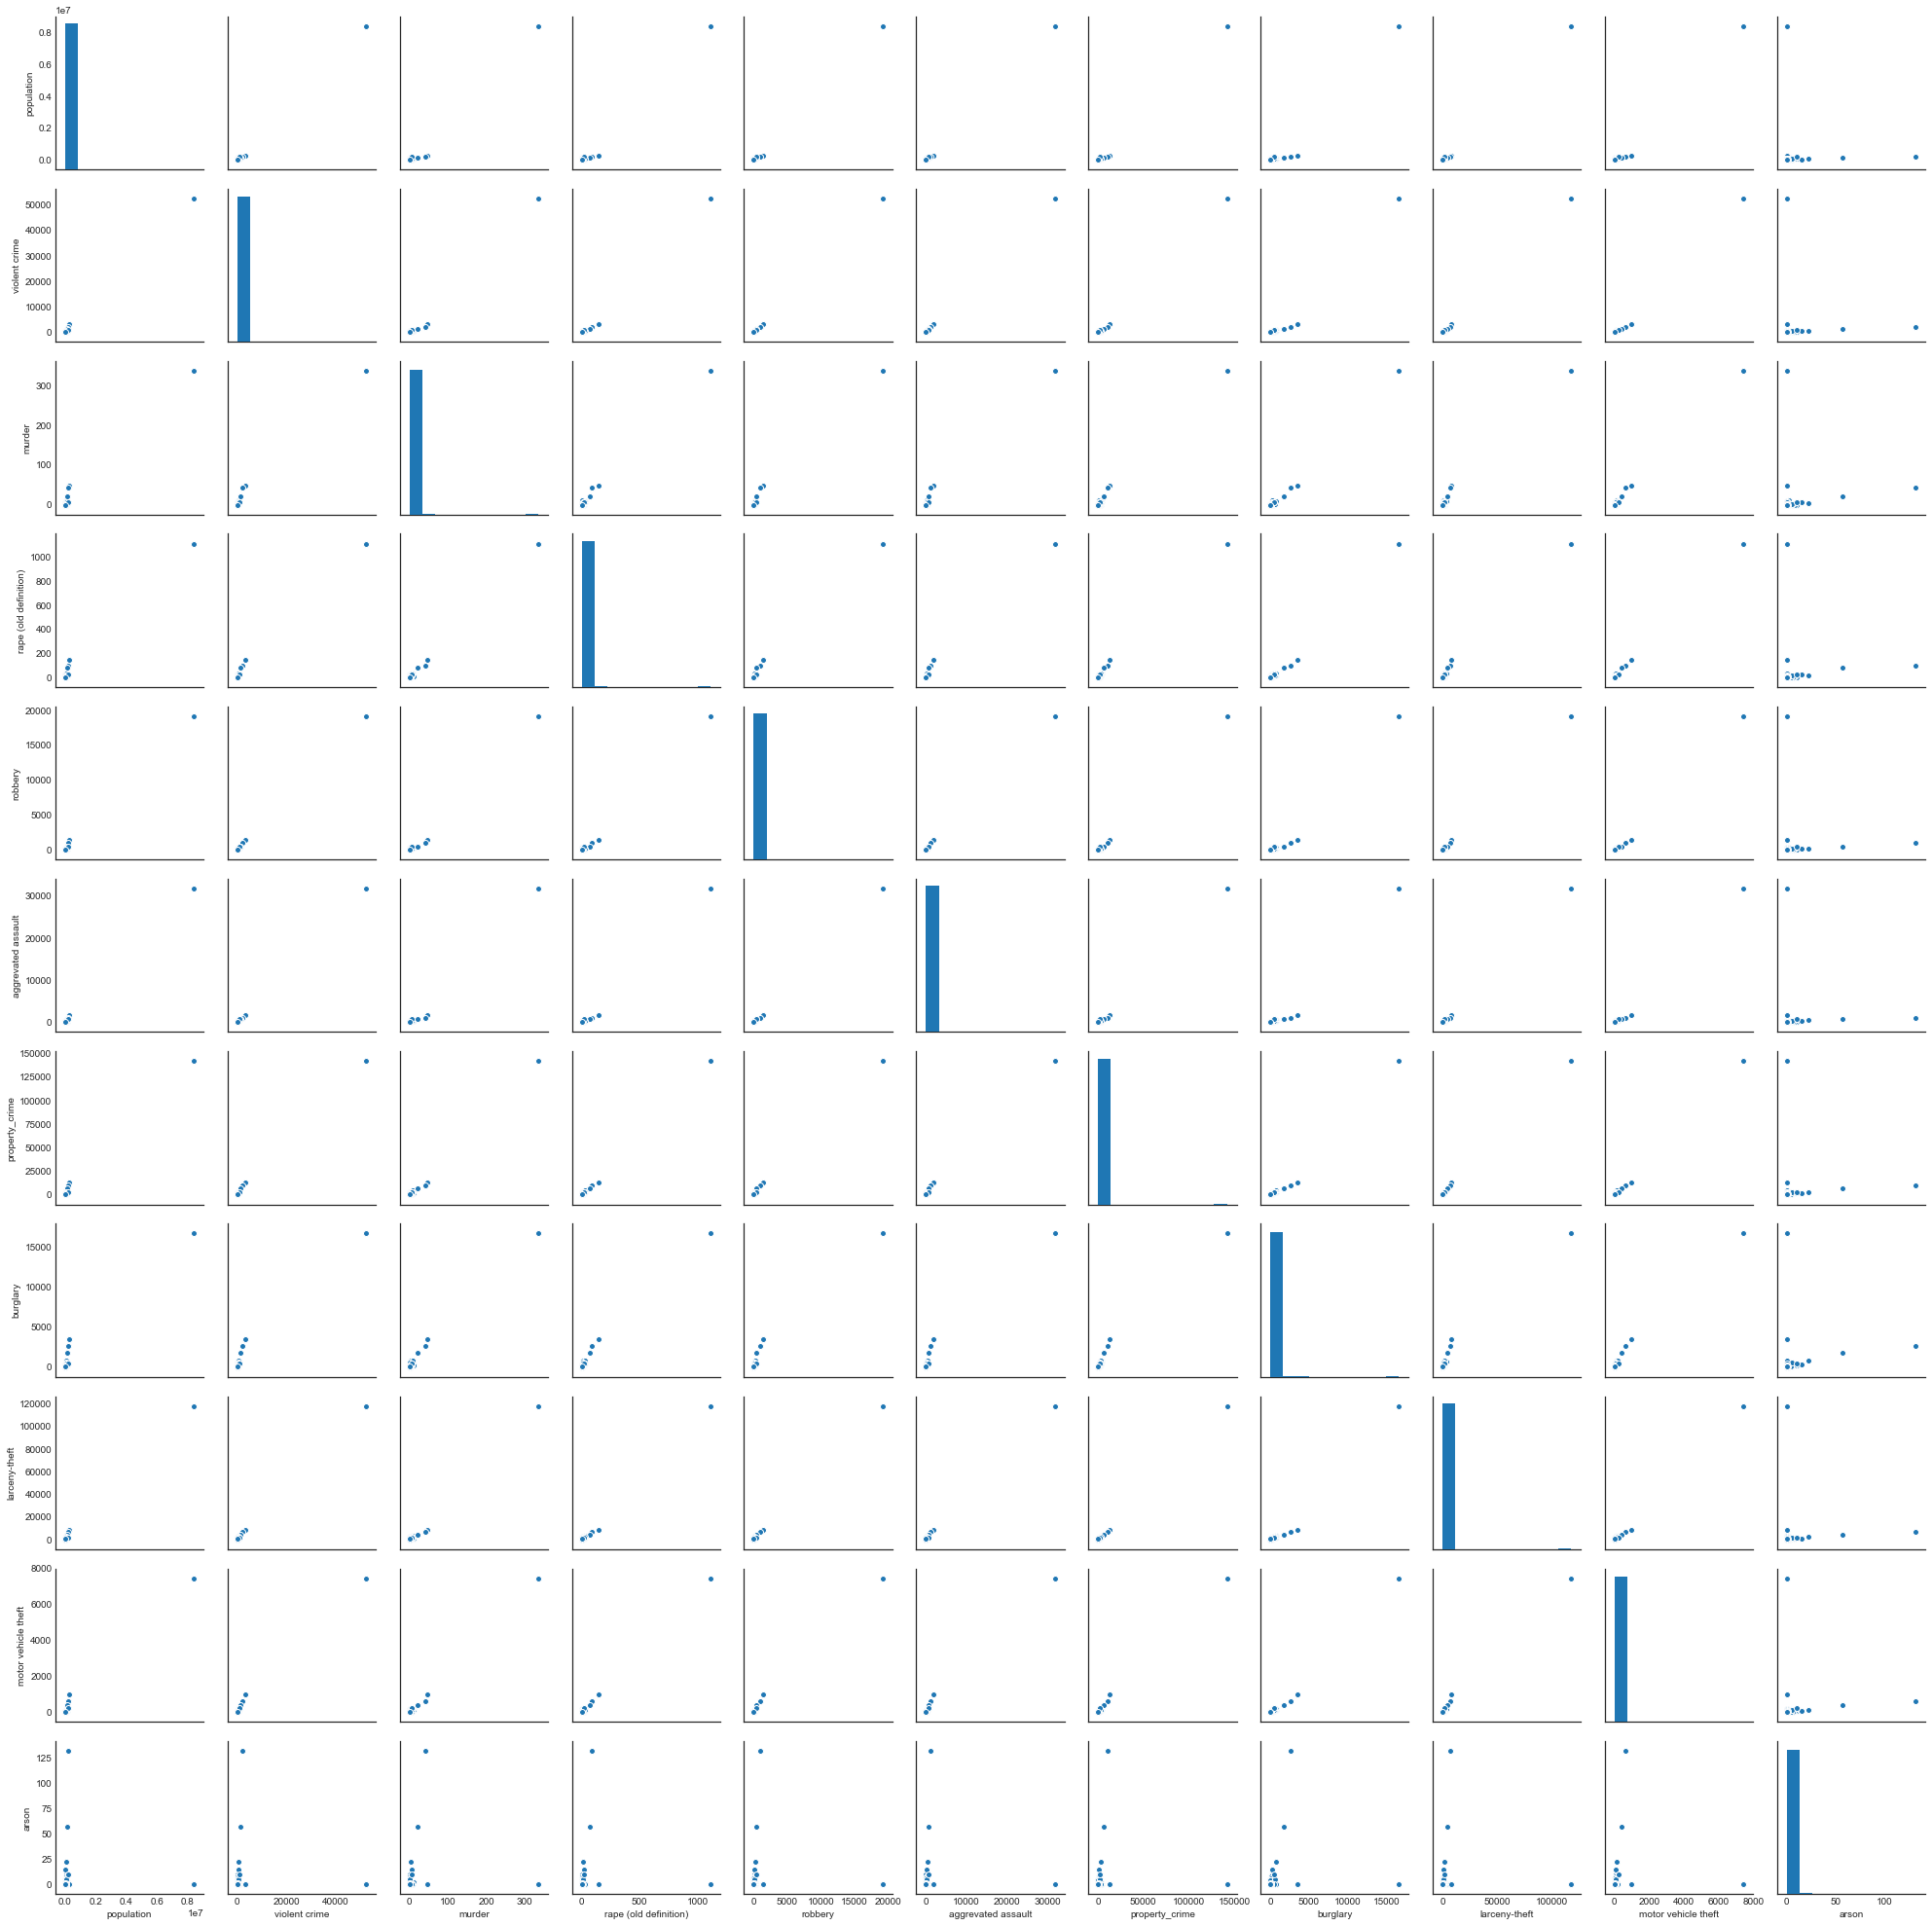

In [8]:
#data exploration
sns.set_style('white')
sns.pairplot(df.iloc[:, 1:], dropna=True)

## The model used to predict property crime is:
## $$Propertycrime = a + Population + Population^2 + Murder + Robbery$$

To do this, I will check for four things:
- Is the prediction linear?
- Is it normally distributed?
- Is the prediction homosedastic?
- Are the features in the prediction lowly correlated?

In [9]:
#feature engineering
df['population_sq'] = (df['population'] ** 2)
df['murder'] = np.where(df['murder'] > 0, 1, 0)
df['robbery'] = np.where(df['robbery'] > 0, 1, 0)

df.head()

,city,population,violent crime,murder,rape (old definition),robbery,aggrevated assault,property_crime,burglary,larceny-theft,motor vehicle theft,arson,population_sq
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,0,3463321
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0,6640929
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,0,8099716
3,Albany,97956,791,1,30,1,526,4090,705,3243,142,0,9595377936
4,Albion Village,6388,23,0,3,1,16,223,53,165,5,0,40806544


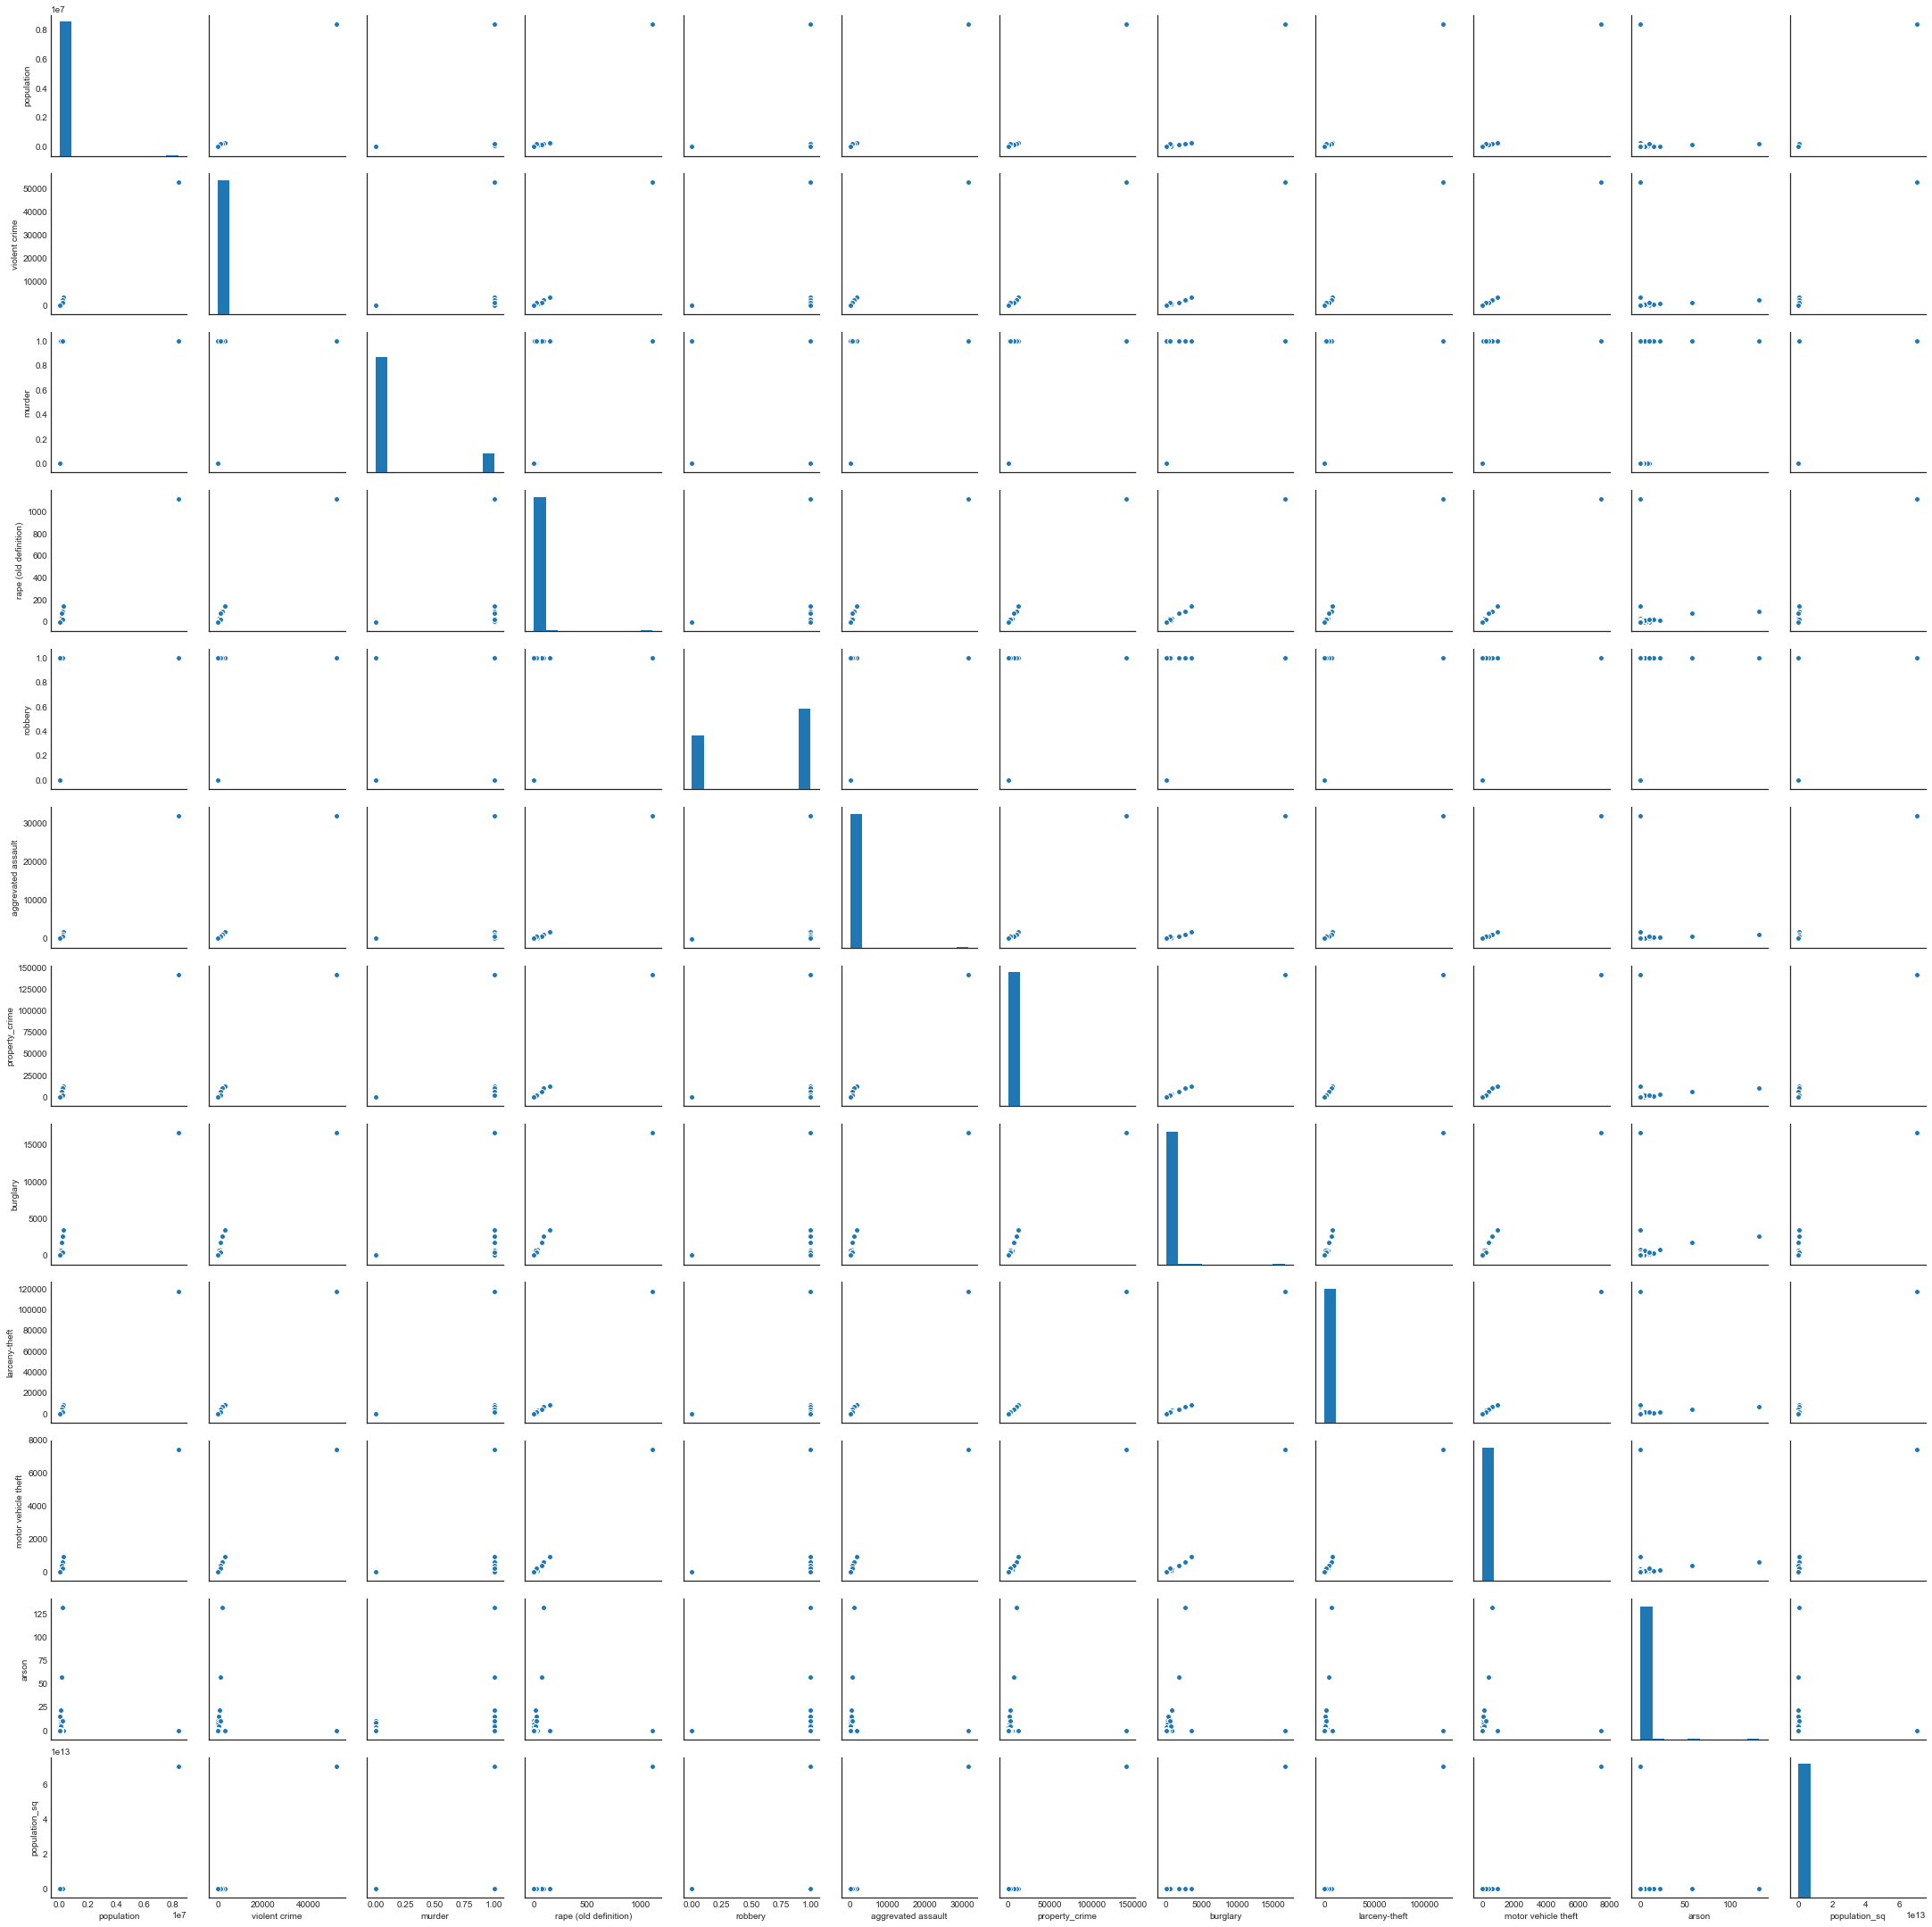

In [10]:
sns.pairplot(df, dropna=True)

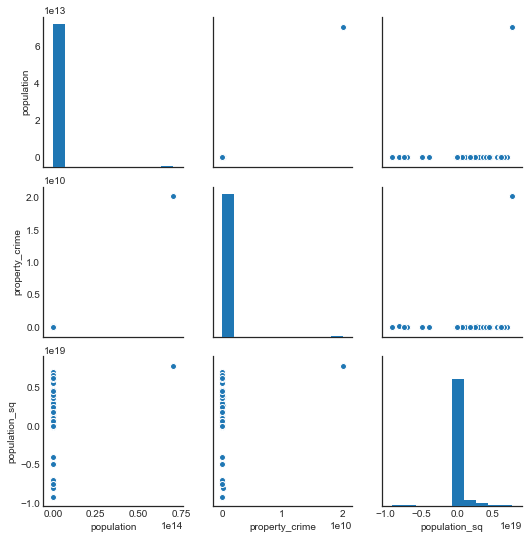

In [11]:
sns.pairplot(df[['population', 'property_crime', 'population_sq']]**2)

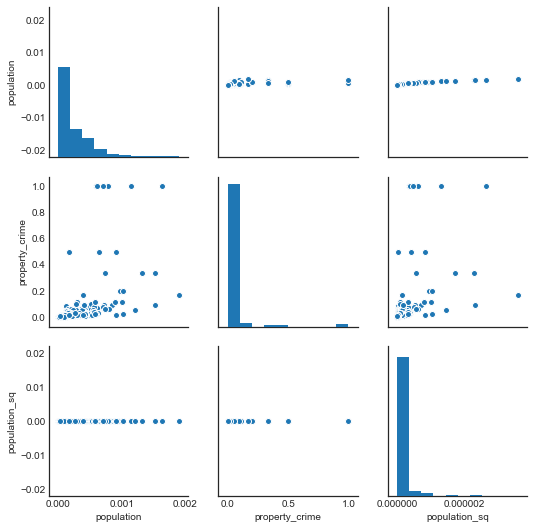

In [12]:
sns.pairplot(1/(df[['population', 'property_crime', 'population_sq']]+1))

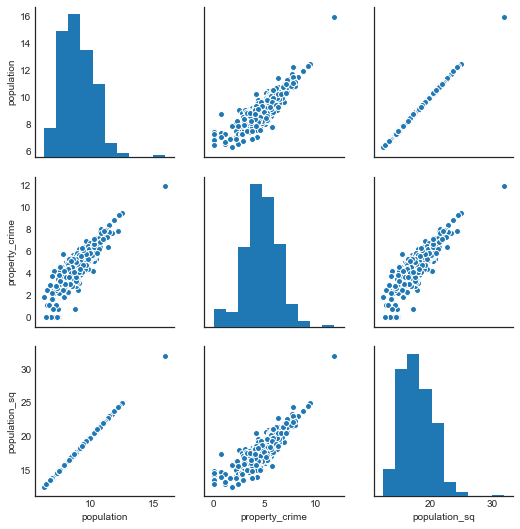

In [13]:
sns.pairplot(np.log(df[['population', 'property_crime', 'population_sq']]+1), dropna=True)

In [14]:
regr = linear_model.LinearRegression()
Y = df['property_crime'].values.reshape(-1, 1)
X = df[['population', 'population_sq', 'murder', 'robbery']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(X, Y))


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
 0.9961247104988709


In [15]:
#rsquared is high, probably overfitting. Try to reduce it
def getLog(x):
    result = 0
    if x > 0:
        result = np.log(x)
    return result

df['log_property_crime'] = df['property_crime'].apply(getLog)
df['log_population'] = df['population'].apply(getLog)
df['log_population_sq'] = df['population_sq'].apply(getLog)

Y = df['log_property_crime'].values.reshape(-1, 1)
X = df[['log_population', 'log_population_sq', 'murder', 'robbery']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(X, Y))


Coefficients: 
 [[-1.69739211e+13  8.48696054e+12  2.43652344e-01  9.18334961e-01]]

Intercept: 
 [-4.32743829]

R-squared:
 0.7950754770805147


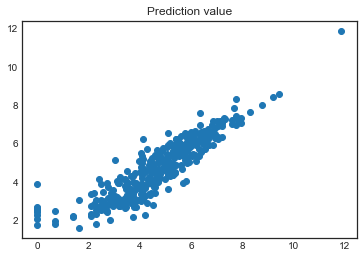

In [16]:
#check if line plot is linear
outcome = Y
predicted = regr.predict(X).ravel()

plt.scatter(outcome, predicted)
plt.title('Prediction value')
plt.show()

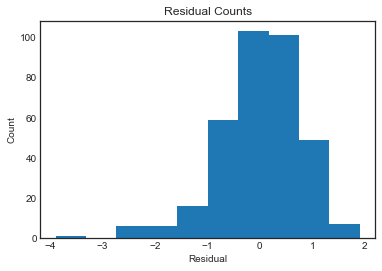

In [17]:
#check if plot has normal distribution
actual = df['log_property_crime']
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

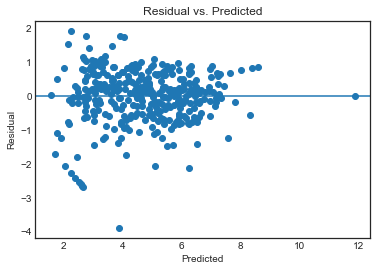

In [18]:
#check if errors are consistent for all predicted values
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

,log_population,log_population_sq,murder,robbery
log_population,1.000,1.000,0.503,0.582
log_population_sq,1.000,1.000,0.503,0.582
murder,0.503,0.503,1.000,0.313
robbery,0.582,0.582,0.313,1.000


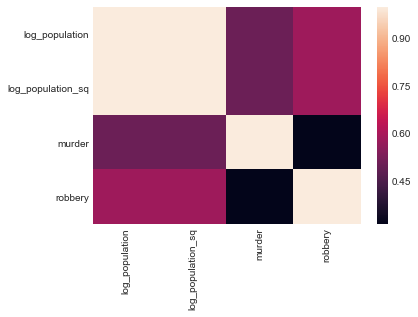

In [19]:
#check if features aren't correlated or not really correlated
display(X.corr())
sns.heatmap(X.corr())

In [20]:
#get rid of similar features like population_sq and log_population_sq
df = df.drop(['log_population_sq', 'population_sq'], axis=1)
#get rid of columns not being used
df = df.drop(['property_crime', 'population'], axis=1)

Y = df['log_property_crime'].values.reshape(-1, 1)
X = df[['log_population', 'murder', 'robbery']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(X, Y))


Coefficients: 
 [[0.95770318 0.24300178 0.91957639]]

Intercept: 
 [-4.45994473]

R-squared:
 0.7951384544470801


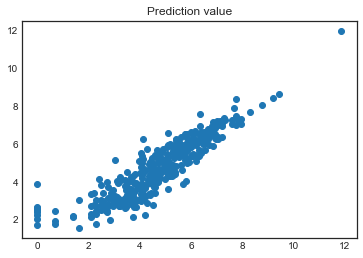

In [21]:
#check if line plot is still linear
outcome = Y
predicted = regr.predict(X).ravel()

plt.scatter(outcome, predicted)
plt.title('Prediction value')
plt.show()

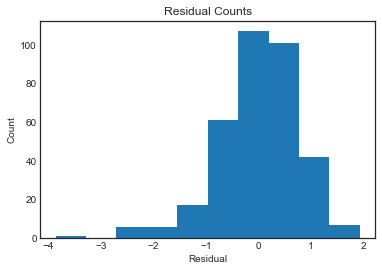

In [22]:
#check if plot has normal distribution
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

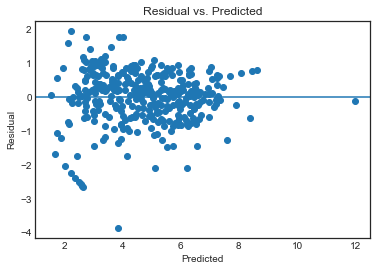

In [23]:
#check if errors are consistent for all predicted values
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [24]:
#original model formula
linear_formula = 'log_property_crime ~ log_population+murder+robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()

print('Params: \n', lm.params)
print('\nPvalues: \n', lm.pvalues)
print('\nRsquared:', lm.rsquared)
print('\nConfidence Interval: \n', lm.conf_int())

Params: 
 Intercept        -4.460
log_population    0.958
murder            0.243
robbery           0.920
dtype: float64

Pvalues: 
 Intercept        0.000
log_population   0.000
murder           0.084
robbery          0.000
dtype: float64

Rsquared: 0.7951384544470801

Confidence Interval: 
                     0      1
Intercept      -5.199 -3.721
log_population  0.867  1.048
murder         -0.033  0.519
robbery         0.711  1.128
